In [1]:
import cryptocompare_fede
from datetime import datetime

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = []
#assets = ["BTC", "ETH", "LTC", "XRP", "ZEC", "BNB"]
assets = ["BTC", "ETH", "LTC", "XRP", "ZEC"]
for asset in assets:
    print("Downloading "+asset+"...")
    new_data = cryptocompare_fede.get_historical_price_day(asset, 'USD', 1000)
    new_data_table = pd.DataFrame(data = new_data["Data"])
    new_data_table = new_data_table.rename(index=str, columns={"time":"Date"})
    new_data_table = new_data_table.rename(index=str, columns={"close":asset})
    new_data_table.index = pd.to_datetime(new_data_table["Date"],  unit='s')
    data.append(new_data_table[asset])

table = pd.concat([idata for idata in data], axis=1)
#table['risk_free'] = pd.Series([pow(1.065, x/365.0) for x in range(table.shape[0])], index=table.index)
num_assets = table.shape[1]

In [3]:
table = table.dropna()
table = table[(table.T > 0).all()]
table.head()

,BTC,ETH,LTC,XRP,ZEC
Date,,,,,
2016-10-28,686.24,11.08,3.949,0.007800,5000.0
2016-10-29,714.95,10.39,4.054,0.007732,4000.0
2016-10-30,697.27,11.22,3.964,0.008023,650.0
2016-10-31,698.67,10.91,3.964,0.007979,1600.0
2016-11-01,726.76,10.75,4.063,0.008028,1550.0


/home/fedecaccia/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price in $')

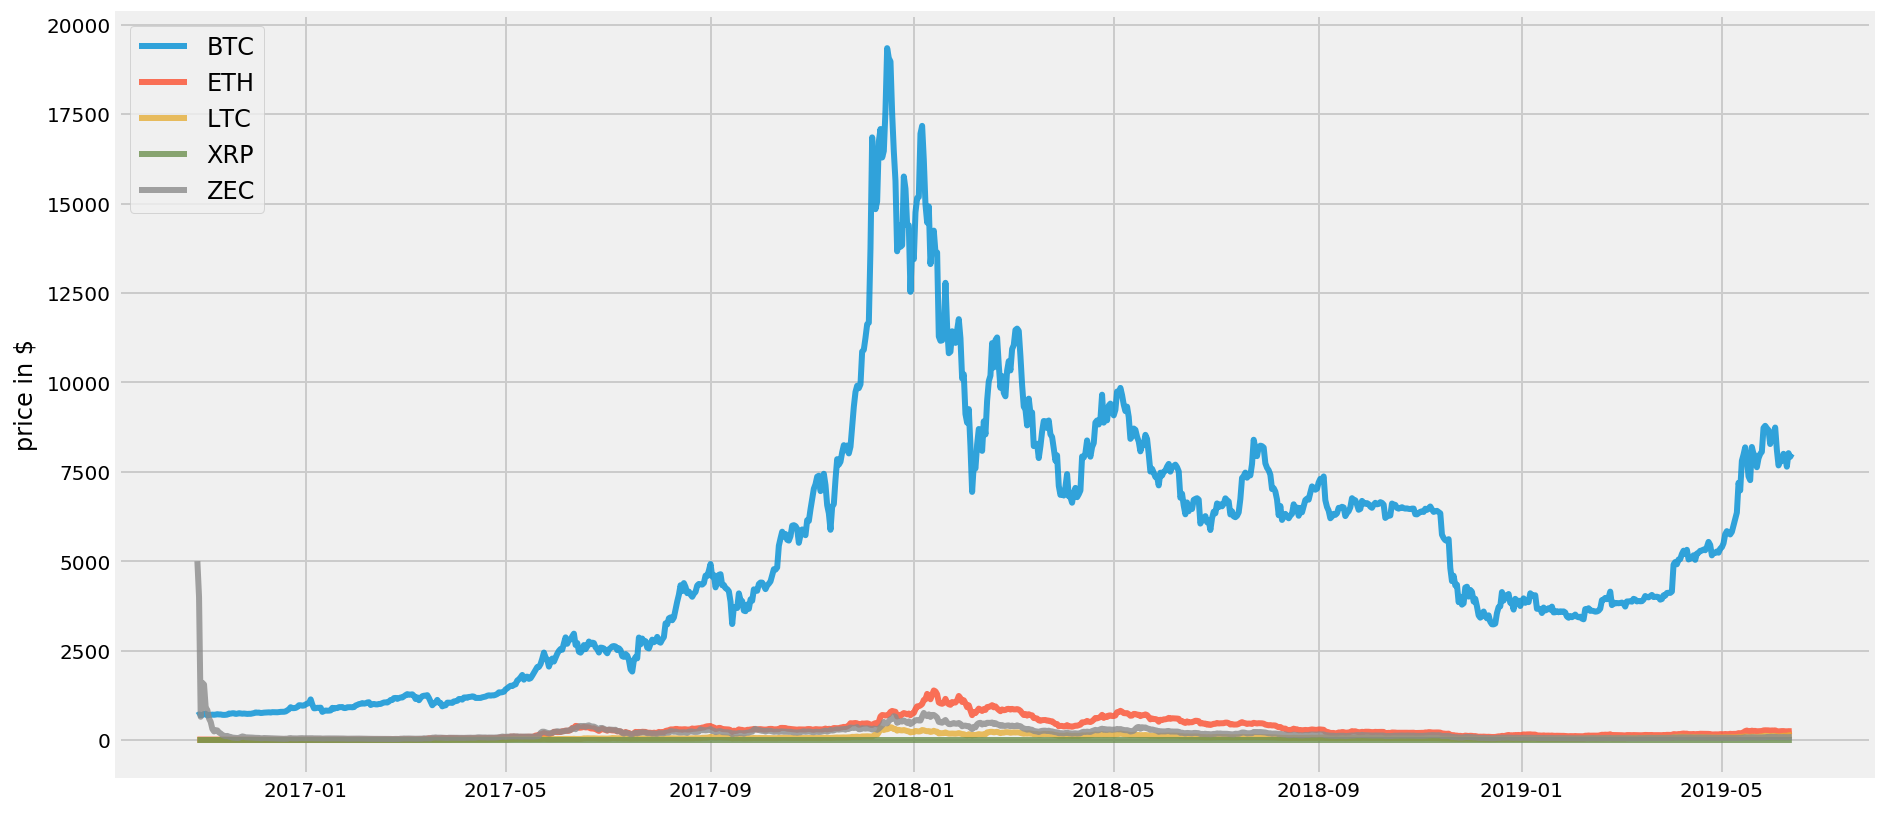

In [4]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

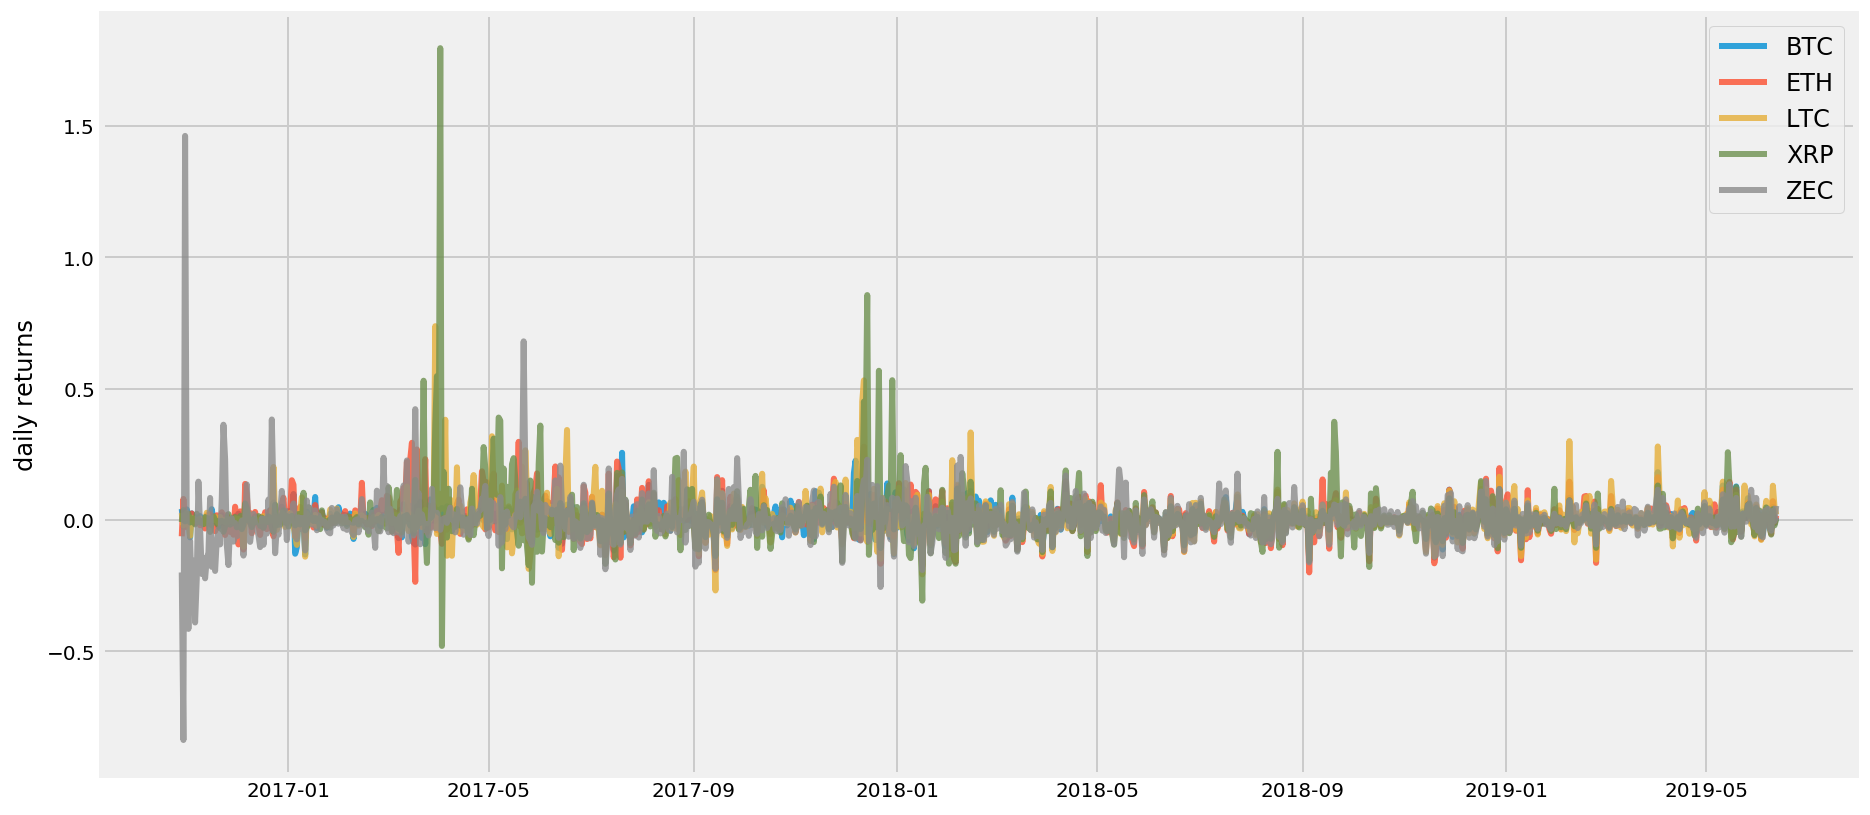

In [5]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [6]:
trading_days_per_year = 365

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *trading_days_per_year
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(trading_days_per_year)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [7]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.065

# Numerical Minimization

In [8]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [9]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [10]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [11]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualized Return:", round(rp,2))
    print ("Annualized Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print ("Annualized Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    
    print ("-"*80)
    an_vol = np.std(returns) * np.sqrt(trading_days_per_year)
    an_rt = mean_returns * trading_days_per_year
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","Annualized return",round(an_rt[i],2),", Annualized volatility:",round(an_vol[i],2))
    print ("-"*80) 
    
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, rp, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)
    
    # weights saved on x
    #pprint(efficient_portfolios["x"])    
    
    #fig, ax = plt.subplots(figsize=(10, 7))
    plt.scatter(an_vol,an_rt,marker='o',s=200)
    for i, txt in enumerate(table.columns):
        plt.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 2.03
Annualized Volatility: 0.98


              BTC    ETH    LTC    XRP  ZEC
allocation  27.76  25.81  23.59  22.84  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 1.39
Annualized Volatility: 0.82


              BTC    ETH  LTC   XRP   ZEC
allocation  81.85  11.07  0.0  4.39  2.68
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

BTC : Annualized return 1.28 , Annualized volatility: 0.83
ETH : Annualized return 1.86 , Annualized volatility: 1.17
LTC : Annualized return 2.19 , Annualized volatility: 1.35
XRP : Annualized return 2.95 , Annualized volatility: 1.95
ZEC : Annualized return 0.06 , Annualized volatility: 1.78
---------------------------------------------------------

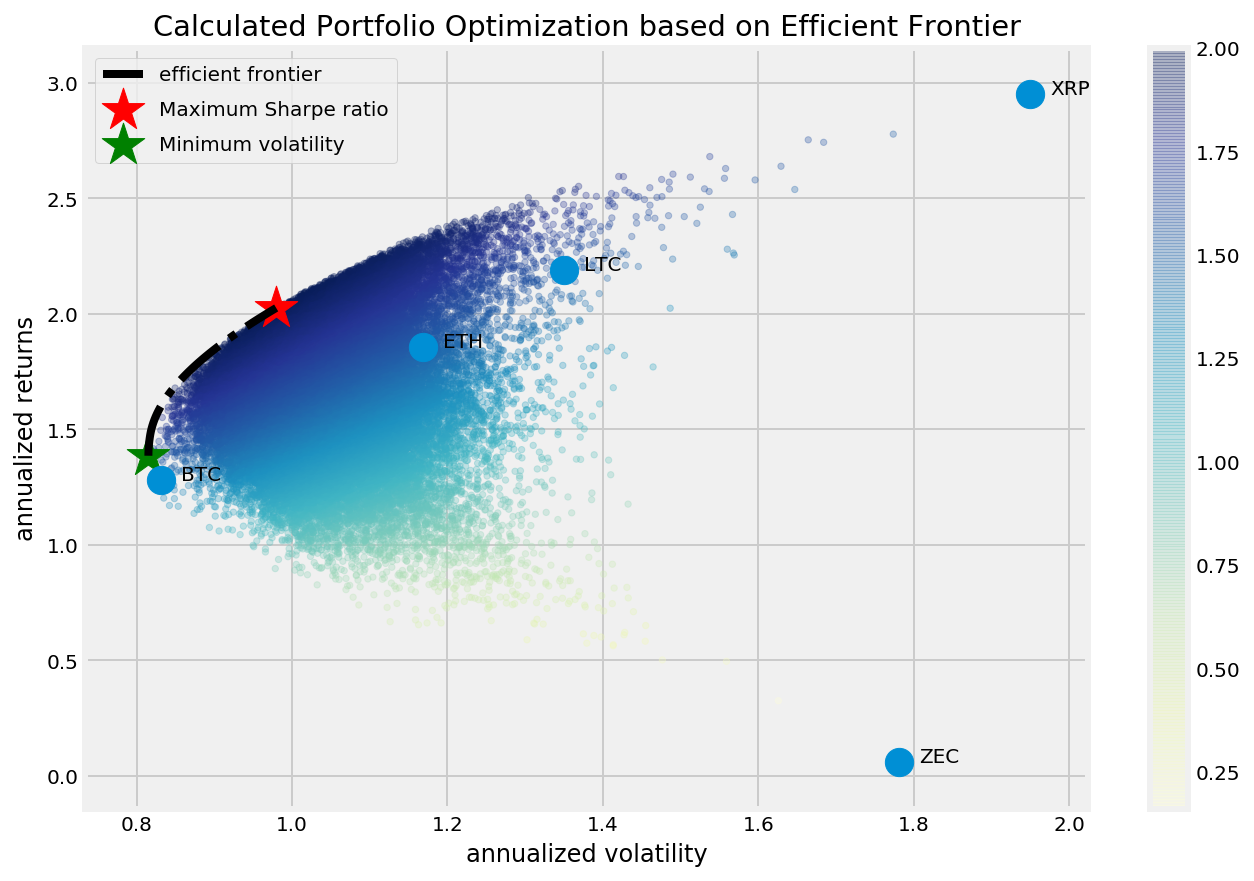

In [12]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Max Sharpe Ratio Portfolio Evolution

In [13]:
def calculate_max_sharpe_ratio(mean_returns, cov_matrix, num_portfolios):
        
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    return {"rp":rp, "sdp": sdp, "msa": max_sharpe_allocation}

In [14]:
dt = 90
increase_tf = 30
tf = dt
portfolios = []

while (tf < len(table.index)):
    ti = tf - dt
    dt_table = table.iloc[ti:tf]
    tf += increase_tf

    returns = dt_table.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    portfolios.append([ti, calculate_max_sharpe_ratio(mean_returns, cov_matrix, num_portfolios)])

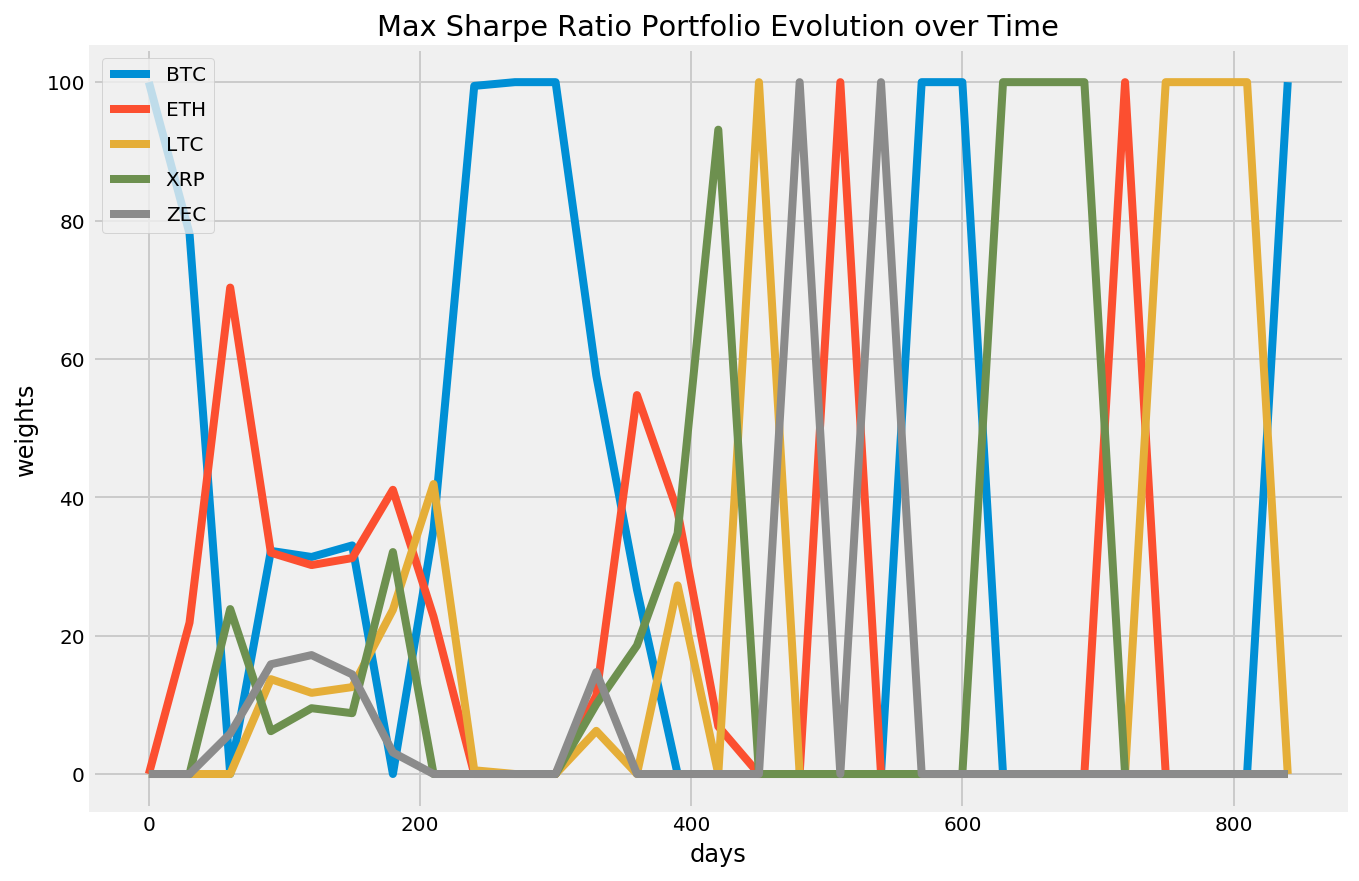

In [15]:
plt.figure(figsize=(10, 7))
x = [portfolios[i][0] for i in range (len(portfolios))]

for asset in assets:
    plt.plot(x, pd.concat([portfolios[i][1]["msa"][asset] for i in range (len(portfolios))]), label=asset)

plt.title('Max Sharpe Ratio Portfolio Evolution over Time')
plt.xlabel('days')
plt.ylabel('weights')
plt.legend(labelspacing=0.8)